Python version used: **3.9.13**

Imports:

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import csv
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd
from gensim.models import Word2Vec
from gensim import utils
import PIL

Check that CUDA is available (when using my own system):

In [2]:
torch.cuda.is_available()

True

# Q1:

(a)

In [194]:
with open("PADL-Q1.csv") as q1_file:
  q1_data = []
  q1_dataset = csv.reader(q1_file, delimiter=',')
  for row in q1_dataset:
    if row[0] != 'x1':
      q1_data.append(row)

In [195]:
pca = PCA(n_components=5)
pca.fit(q1_data)
newData = pca.fit_transform(q1_data)
pca_var_percentage = pca.explained_variance_ratio_
print(pca_var_percentage)

[0.53846279 0.30067823 0.1026325  0.04605826 0.01216823]


In [196]:
three_dims = pca_var_percentage[0]+pca_var_percentage[1]+pca_var_percentage[2]
print("Information retained with 3 variables = %f%%\n"%(three_dims*100.0))
print("Information retained with 4 variables = %f%%"%((three_dims + pca_var_percentage[3])*100.0))

Information retained with 3 variables = 94.177351%

Information retained with 4 variables = 98.783177%


Reducing the dimensionality of the dataset by 1 dimension causes information loss of 1.22%. Reducing it by 2 dimensions (down to 3) causes information loss of 5.82% however it is now possible to plot the dataset on a 3D axis, whereas this is not possible with 4 dimensions. Therefore, D_min = 3.





(b)

In [197]:
pca2 = PCA(n_components=3)
pca2.fit(q1_data)
newData2 = pca2.fit_transform(q1_data)
pca2_components = pca2.components_

In [198]:
i = 1
for line in pca2_components:
    print("PC%i: %f*x1 + %f*x2 + %f*x3 + %f*x4 + %f*x5\n"%(i,line[0],line[1],line[2],line[3],line[4]))
    i+=1

PC1: -0.092819*x1 + 0.025272*x2 + -0.348770*x3 + 0.145083*x4 + -0.920900*x5

PC2: 0.005624*x1 + -0.298705*x2 + -0.114221*x3 + -0.940623*x4 + -0.113695*x5

PC3: 0.112668*x1 + -0.133156*x2 + 0.914203*x3 + -0.023934*x4 + -0.365014*x5



# Q2:

Read data into a Pandas Dataframe:

In [199]:
q2_data = pd.read_csv("PADL-Q2-train.csv")
q2_data

,x,y,z,w,out
0,66.4774,1.6495,0.7613,0.1,-0.0209
1,15.1422,2.2292,0.0050,0.1,0.1281
2,87.9859,2.1449,0.2217,0.1,0.1289
3,79.4979,2.0901,0.0396,0.1,0.1442
4,36.5181,2.0992,0.2040,0.0,-0.0131
...,...,...,...,...,...
75,7.5622,2.2608,0.0785,0.1,0.3158
76,10.7811,2.0351,0.6939,0.1,0.0325
77,57.3595,2.2470,0.3667,0.0,0.0675
78,4.4803,1.6897,0.0544,0.1,0.3627


Split into train and test data:

In [200]:
X = q2_data.drop('out', axis=1)
y = q2_data['out']
# Split 70:10 train:test
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.125)

Fit a LR model, compare predicted vs actual values, calculate R2 score:

In [201]:
regr = LinearRegression()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)

r2 = r2_score(y_test,y_pred)

for y1,y2 in zip(y_test,y_pred):
    print(f'Predicted vs actual: {y2:.4f} vs {y1}')

print(f'\nR2 score: {r2:.6f}')

Predicted vs actual: 0.1900 vs 0.1281
Predicted vs actual: 0.0224 vs -0.0131
Predicted vs actual: -0.1493 vs -0.1033
Predicted vs actual: -0.0598 vs -0.0891
Predicted vs actual: -0.1703 vs 0.0811
Predicted vs actual: -0.0295 vs 0.0004
Predicted vs actual: -0.0580 vs -0.0329
Predicted vs actual: 0.0673 vs 0.0328
Predicted vs actual: -0.1008 vs -0.0656
Predicted vs actual: -0.0906 vs -0.0052

R2 score: -0.725413


# Q3:

(a)

In [202]:
with open("PADL-Q3.txt",'r') as q3_file:
    words = []
    raw_data = q3_file
    for line in q3_file:
        for word in line.split():
            words.append(word)

The following tile removes punctuation from the text then selects all triplets where the middle word is "and". It then selects the before and after words and adds them as a 3-tuple into a list.

In [203]:
punctuation = """!'()*+,— -./:;<=>?@[\]^_`{|"}~#$%&"""
words_no_punc = [''.join(char for char in word if char not in punctuation) for word in words]
triplets = []
for i in range(1,len(words)-1):
    if words_no_punc[i] == "and":
        triplets.append((words_no_punc[i-1],words_no_punc[i],words_no_punc[i+1]))
triplets

[('States', 'and', 'most'),
 ('cost', 'and', 'with'),
 ('eclipses', 'and', 'predominates'),
 ('emotions', 'and', 'that'),
 ('reasoning', 'and', 'observing'),
 ('gibe', 'and', 'a'),
 ('motives', 'and', 'actions'),
 ('delicate', 'and', 'finely'),
 ('him', 'and', 'that'),
 ('dubious', 'and', 'questionable'),
 ('happiness', 'and', 'the'),
 ('books', 'and', 'alternating'),
 ('cocaine', 'and', 'ambition'),
 ('drug', 'and', 'the'),
 ('crime', 'and', 'occupied'),
 ('faculties', 'and', 'extraordinary'),
 ('clues', 'and', 'clearing'),
 ('Trincomalee', 'and', 'finally'),
 ('delicately', 'and', 'successfully'),
 ('friend', 'and', 'companion'),
 ('wooing', 'and', 'with'),
 ('again', 'and', 'to'),
 ('lit', 'and', 'even'),
 ('chest', 'and', 'his'),
 ('mood', 'and', 'habit'),
 ('attitude', 'and', 'manner'),
 ('dreams', 'and', 'was'),
 ('bell', 'and', 'was'),
 ('cigars', 'and', 'indicated'),
 ('case', 'and', 'a'),
 ('fire', 'and', 'looked'),
 ('seven', 'and', 'a'),
 ('lately', 'and', 'that'),
 ('clumsy

(b)

This procedure iterates over all words in L and finds any triplet where the last 3 letters of the final word of the triplet are the same 3 letters as the last 3 letters of word W chosen from L.

In [204]:
L = ['gold','diamond','robbery','bank','police']
matches = []
for W in L:
    for t in triplets:
        if t[2][-3:] == W[-3:]:
            matches.append((' '.join(t),W))

matches

[('away and told', 'gold'),
 ('rapidly and told', 'gold'),
 ('Silk and Gold', 'gold'),
 ('indemnify and hold', 'gold'),
 ('delicacy and every', 'robbery'),
 ('pay and very', 'robbery'),
 ('ten and every', 'robbery'),
 ('Abbots and Archery', 'robbery'),
 ('police and every', 'robbery'),
 ('Air and scenery', 'robbery'),
 ('long and very', 'robbery'),
 ('armchair and cheery', 'robbery'),
 ('police and very', 'robbery'),
 ('do and Frank', 'bank'),
 ('mercifully and thank', 'bank'),
 ('help and advice', 'police')]

(c)

In [205]:
class Q3Data(object):
    def __init__(self,dir):
        self.dir = dir
    def __iter__(self):
        with open("PADL-Q3.txt") as q3_dataset:
            dataset = []
            for line in q3_dataset:
                dataset.append(utils.simple_preprocess(line))
        for i in range(len(dataset)-1):
            if dataset[i] == []:
                dataset[i] = dataset[i-1] + dataset[i+1]
            yield dataset[i]

In [206]:
sentences = Q3Data("PADL-Q3.txt")
model = Word2Vec(min_count=4)
model.build_vocab(sentences)
model.train(sentences,total_examples=12753,epochs=25)

(2485374, 3708075)

In [207]:
similarities = []
for match in matches:
    triplet = match[0].split()
    try:
        sim = model.wv.similarity(triplet[0].lower(),triplet[2].lower())
        print(triplet[0],sim,triplet[2])
        similarities.append((sim,triplet[0],triplet[2]))
    except KeyError:
        print("\nThe word '"+triplet[0]+"' or the word '"+triplet[2]+"' is not in the text above min_count times, therefore the similarity cannot be computed\n")

away 0.29478028 told
rapidly 0.082591295 told
Silk 0.62786156 Gold

The word 'indemnify' or the word 'hold' is not in the text above min_count times, therefore the similarity cannot be computed

delicacy 0.21331194 every
pay 0.31189895 very
ten 0.29076287 every

The word 'Abbots' or the word 'Archery' is not in the text above min_count times, therefore the similarity cannot be computed

police 0.010944551 every

The word 'Air' or the word 'scenery' is not in the text above min_count times, therefore the similarity cannot be computed

long -0.0048855515 very

The word 'armchair' or the word 'cheery' is not in the text above min_count times, therefore the similarity cannot be computed

police 0.010983485 very
do 0.16749296 Frank

The word 'mercifully' or the word 'thank' is not in the text above min_count times, therefore the similarity cannot be computed

help 0.4776602 advice


In [208]:
sorted(similarities,reverse=True)[:5]

[(0.62786156, 'Silk', 'Gold'),
 (0.4776602, 'help', 'advice'),
 (0.31189895, 'pay', 'very'),
 (0.29478028, 'away', 'told'),
 (0.29076287, 'ten', 'every')]

# Q4:

Define MLP using Fully Connected and ReLU layers only:

In [209]:
class MultiplyMLP(nn.Module):
    def __init__(self, inputSize, hiddenSize):
        super(MultiplyMLP, self).__init__()
        self.linear1 = nn.Linear(inputSize,hiddenSize)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hiddenSize,1)
    
    def forward(self,x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

Function to generate random training data in the range [-100,100):

In [210]:
def generate_data(low,high,num_samples):
    x1 = np.random.uniform(low,high, num_samples)
    x2 = np.random.uniform(low,high, num_samples)
    y_true = x1 * x2
    data = torch.tensor(np.column_stack((x1, x2))).to(torch.float32)
    labels = torch.tensor(y_true).reshape(-1, 1)
    return data, labels

Run training loop to train on random data:

In [211]:
# Define hyperparameters
input_size = 2
hidden_size = 64
learning_rate = 0.01
num_epochs = 1000
batch_size = 32
num_samples = 3000
# Use L1Loss for absolute error
criterion = nn.L1Loss()

q4_model = MultiplyMLP(input_size,hidden_size)
optimiser = optim.Adam(q4_model.parameters(), lr=learning_rate)

# Create list to store loss values in for plotting
losses = []

for epoch in range(num_epochs):
    for i in range(0,num_samples,batch_size):
        data,labels = generate_data(-100,100,batch_size)

        output = q4_model(data)
        loss = criterion(output, labels)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    if (epoch+1) % 250 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    if (epoch+1) % 10 == 0:
        losses.append(loss.item())



Epoch [250/1000], Loss: 394.5793
Epoch [500/1000], Loss: 40.5162
Epoch [750/1000], Loss: 22.6733
Epoch [1000/1000], Loss: 24.2634


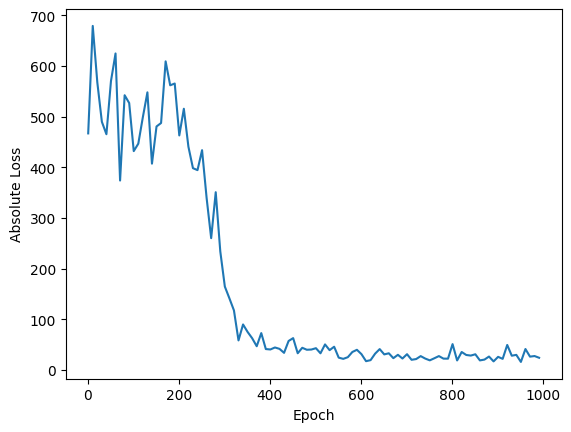

In [212]:
epochs = np.arange(1,1001,10)
plt.xlabel("Epoch")
plt.ylabel("Absolute Loss")
plt.plot(epochs,losses)

Evaluate and compare random example's predicted value vs real value:

In [213]:
x,y = generate_data(-100,100,1)

with torch.no_grad():
    q4_model.eval()
    y_pred = q4_model(x)
l1 = criterion(y_pred,y).item()

print(f'x1, x2 = {x[0][0]:.6f}, {x[0][1]:.6f}')
print(f'Predicted vs Actual value: {y_pred[0][0]:.6f} vs {y[0][0]:.6f}')
print(f'Test L1 Loss: {l1:.6f}')

x1, x2 = -61.8288307, 16.5190983
Predicted vs Actual value: -1026.5977783203125 vs -1021.3565634413322
Test L1 Loss: 5.2412149


Generate 100 random samples to test and evaluate average loss within range of training data:

In [214]:
x_val,y_val = generate_data(-100,100,100)
q4_model.eval()

total_loss = 0
for i in range(100):
    with torch.no_grad():
        y_pred = q4_model(x_val[i])
        l1 = criterion(y_pred,y_val[i])
    total_loss+=l1

print(f'Average loss within range of training data = {total_loss/100:.6f}')

Average loss within range of training data = 13.8399358


Generate 100 random samples outside range of training data and calculate average loss:

In [215]:
x_test_neg,y_test_neg = generate_data(-500,-100,50)
x_test_pos,y_test_pos = generate_data(100.01,500,50)

total_loss = 0
for i in range(50):
    with torch.no_grad():
        y_pred = q4_model(x_test_neg[i])
        l1 = criterion(y_pred,y_test_neg[i])
    total_loss+=l1

for i in range(50):
    with torch.no_grad():
        y_pred = q4_model(x_test_pos[i])
        l1 = criterion(y_pred,y_test_pos[i])
    total_loss+=l1

print(f'Average loss outside range of training data = {total_loss/100:.6f}')

Average loss outside range of training data = 52959.9999565


# Q5:

(a)

In [47]:
class ClocksDataset(Dataset):
    """Custom Clocks Dataset"""

    def __init__(self,img_dir,transforms=None):

        self.img_dir = img_dir
        self.transforms=transforms
        
        images = []
        labels = []

        for i in range(10000):
            images.append(f"{i:04d}.png")
            labels.append(f"{i:04d}.txt")
        
        self.images = sorted(images)
        self.labels = sorted(labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        img_path = self.images[idx]
        label_path = self.labels[idx]
        if self.transforms:
            PIL_image = PIL.Image.open(self.img_dir + img_path)
            PIL_image = self.transforms(PIL_image)
            image = PIL_image.to(torch.float32)/255.0
        else:
            image = (read_image(self.img_dir + img_path)).to(torch.float32)/255.0
        
        label = self.read_label(self.img_dir + label_path)

        return image,label
    
    def read_label(self,label_path):
        with open(label_path) as label_file:
            raw_label = label_file.read()
        label_vals = raw_label.split(':')
        label_vals = [float(val) for val in label_vals]
        hours = label_vals[0]
        mins = label_vals[1]
        return torch.tensor((hours,mins), dtype=torch.float32)

In [25]:
batch_size = 32
dataset = ClocksDataset("clocks_dataset/train/")
train_data,validation_data = torch.utils.data.random_split(dataset,[9600,400])

In [26]:
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(validation_data,batch_size=batch_size,shuffle=True)

images,labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 448, 448])
torch.Size([32, 2])


(b)

In [6]:
class ClocksCNN(nn.Module):
    def __init__(self):
        super(ClocksCNN,self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # 16 x 224 x 224
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # 32 x 112 x 112
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # 64 x 56 x 56
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4,stride=4), # 128 x 14 x 14
            nn.Flatten(),
            nn.Dropout(0.5)
        )

        self.MLPhours = nn.Sequential(
            nn.Linear(in_features=128*14*14,out_features=192),
            nn.ReLU(),
            nn.Linear(in_features=192,out_features=12)
        )

        self.MLPmins = nn.Sequential(
            nn.Linear(in_features=128*14*14,out_features=96),
            nn.ReLU(),
            nn.Linear(in_features=96,out_features=1)
        )


    def forward(self,x):
        x = self.layers(x)
        x = x.view(x.size(0),-1)
        hours = self.MLPhours(x)
        mins = self.MLPmins(x)
        return hours,mins.view(-1)

q5_model = ClocksCNN()

In [7]:
total_params = sum(p.numel() for p in q5_model.parameters() if p.requires_grad)
print(total_params)

7325965


(c)

TODO: Justify loss functions

In [8]:
criterion_h = nn.CrossEntropyLoss()
criterion_m = nn.MSELoss()

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

q5_model = q5_model.to(device)
q5_model.train()

num_epochs = 15
optim = torch.optim.SGD(q5_model.parameters(),lr=0.005)
iterations_per_epoch=300

losses_h, losses_m = [],[]

for epoch in range(num_epochs):
    for i,(images,labels) in enumerate(train_loader):
        images,labels = images.to(device),labels.to(device)
        labels_h,labels_m = labels[:,0],labels[:,1]
        h,m = q5_model(images)
        loss1 = criterion_h(h,labels_h.long())
        loss2 = criterion_m(m,labels_m)
        loss = loss1/3 + loss2/100
        optim.zero_grad()
        loss.backward()
        optim.step()

        if (i+1)%50 == 0:
            print('Epoch [{}/{}], Iteration [{}/{}], Loss (hours): {:.4f}, Loss (mins): {:.4f}'.format(epoch+1, num_epochs, i+1, iterations_per_epoch, loss1.item(), loss2.item()))
            losses_h.append(loss1.item())
            losses_m.append(loss2.item())

Epoch [1/15], Iteration [50/300], Loss (hours): 2.4431, Loss (mins): 413.6765
Epoch [1/15], Iteration [100/300], Loss (hours): 2.0686, Loss (mins): 199.8356
Epoch [1/15], Iteration [150/300], Loss (hours): 1.9567, Loss (mins): 207.4039
Epoch [1/15], Iteration [200/300], Loss (hours): 1.6682, Loss (mins): 122.6985
Epoch [1/15], Iteration [250/300], Loss (hours): 1.8313, Loss (mins): 184.0784
Epoch [1/15], Iteration [300/300], Loss (hours): 1.4521, Loss (mins): 164.6139
Epoch [2/15], Iteration [50/300], Loss (hours): 1.2929, Loss (mins): 168.1059
Epoch [2/15], Iteration [100/300], Loss (hours): 1.5278, Loss (mins): 140.5015
Epoch [2/15], Iteration [150/300], Loss (hours): 1.1485, Loss (mins): 134.2022
Epoch [2/15], Iteration [200/300], Loss (hours): 1.0819, Loss (mins): 119.8272
Epoch [2/15], Iteration [250/300], Loss (hours): 0.9528, Loss (mins): 155.1753
Epoch [2/15], Iteration [300/300], Loss (hours): 1.0264, Loss (mins): 223.1458
Epoch [3/15], Iteration [50/300], Loss (hours): 0.9478

Export network weights

In [14]:
torch.save(q5_model.state_dict(),'weights.pkl')

Text(0.5, 1.0, 'Hours prediction loss')

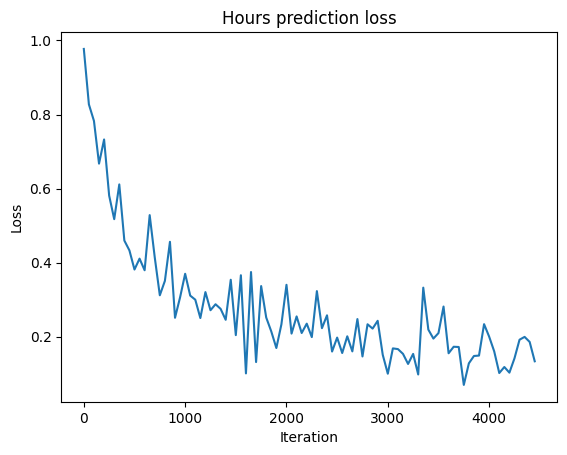

In [23]:
x = np.arange(0,4500,50)
losses_h = [val/2.5 for val in losses_h]
plt.plot(x,losses_h)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Hours prediction loss")

Text(0.5, 1.0, 'Minutes prediction loss')

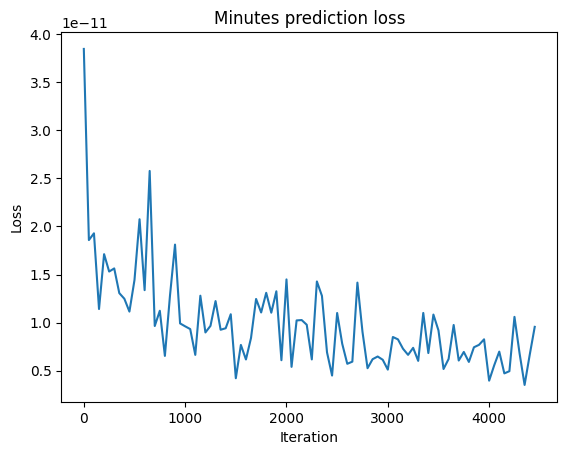

In [35]:
losses_m = [val/400 for val in losses_m]
plt.plot(x,losses_m)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Minutes prediction loss")

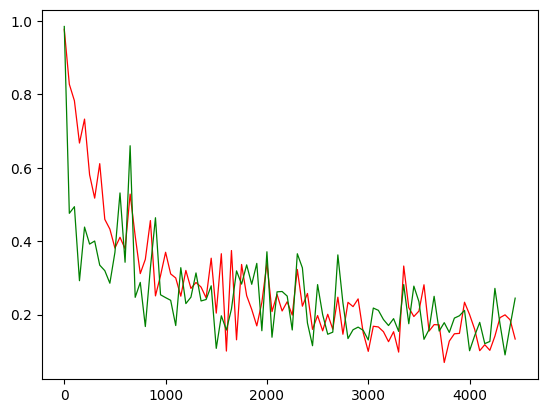

In [31]:
plt.plot(x,losses_h,'r',linewidth=0.9)
plt.plot(x,losses_m,'g',linewidth=0.9)
plt.show()

Make predictions on validation set with trained model:

In [12]:
def time_diff(hpred,mpred,h_real,m_real):
    mins_pred = hpred*60 + mpred
    mins_real = h_real*60 + m_real

    diff = abs(mins_real-mins_pred)
    return min(diff,720-diff)

Actual time: 4:5
Predicted time: 4:9
Error: 4


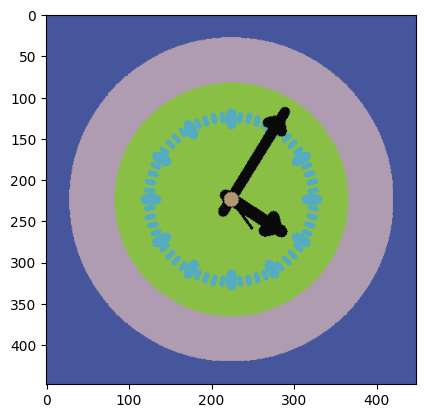

In [40]:
device = torch.device("cpu")
q5_model = q5_model.to(device)
q5_model.eval()
images_v, labels_v = next(iter(valid_loader))

pred_h_valid,pred_m_valid = q5_model(images_v)

actual_time = (int(labels_v[0][0]),int(labels_v[0][1]))
# if minutes is over 60, add however many hours to the hours value and use the remainder for minutes
prediction_mins = divmod(int(round(pred_m_valid[0].item())),60)
predicted_time = (int(pred_h_valid[0].argmax().item())+prediction_mins[0],prediction_mins[1])
plt.imshow(images_v[0].permute(1,2,0))
print("Actual time: %d:%d"%(actual_time[0],actual_time[1]))
print("Predicted time: %d:%d"%(predicted_time[0],predicted_time[1]))
print("Error: %d"%time_diff(predicted_time[0],predicted_time[1],actual_time[0],actual_time[1]))

In [15]:
device = torch.device("cpu")
q5_model = q5_model.to(device)
q5_model.eval()
valid_errors = []
for i in range(12):
    images_v, labels_v = next(iter(valid_loader))
    h_pred,m_pred = q5_model(images_v)
    for j in range(len(h_pred)):
        actual_time = (int(labels_v[j][0]),int(labels_v[j][1]))
        
        prediction_mins = divmod(int(round(pred_m_valid[j].item())),60)
        predicted_time = (int(pred_h_valid[j].argmax().item())+prediction_mins[0],prediction_mins[1])

        valid_errors.append(time_diff(predicted_time[0],predicted_time[1],actual_time[0],actual_time[1]))

In [20]:
valid_errors = np.sort(valid_errors)
np.median(valid_errors)

193.5

# Q6:

In [38]:
# hyperparameters
nz = 100 # size of z vector (generator input)
nc = 3 # number of input channels (colour image so 3)
ngf = 32 # size of feature maps in generator
ndf = 32 # size of feature maps in discriminator

batch_size = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5

In [52]:
transform = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(128),transforms.Normalize(0.5,0.5)])
dataset = ClocksDataset("clocks_dataset/train/",transforms=transform)
dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True)
device = torch.device("cuda"if torch.cuda.is_available() else "cpu")

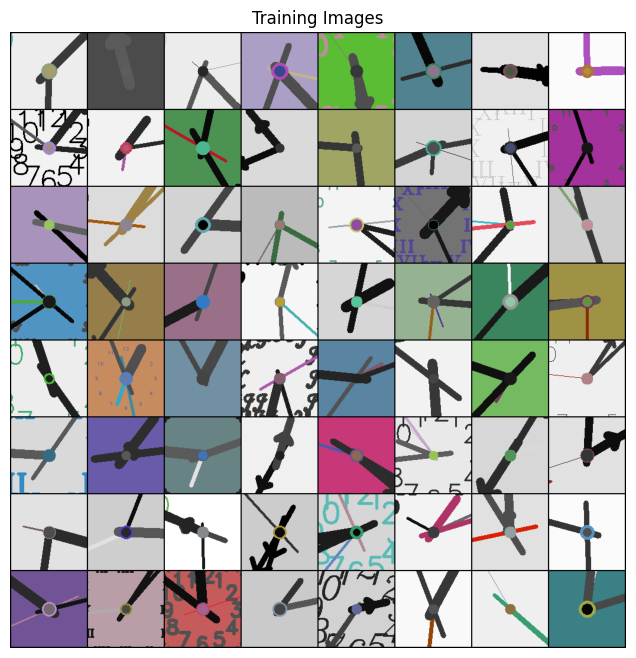

In [53]:
import torchvision.utils as vutils
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [54]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            # Z of size B x nz x 1 x 1
            nn.ConvTranspose2d(nz, ngf*8,4,1,0,bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # Size B x (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8,ngf*4,4,2,1,bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Size B x (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Size B x (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Size B x (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # B x (nc) x 64 x 64
        )
    
    def forward(self, input):
        return self.layers(input)

In [55]:
netG = Generator().to(device)

In [67]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(nc,ndf,4,2,1,bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Size B x (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Size (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Size(ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Size (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            nn.Flatten(),
            nn.Linear(25,1)
        )

    def forward(self,input):
        return self.layers(input)

In [68]:
netD = Discriminator().to(device)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [65]:
criterion_q6 = nn.BCELoss()

real_label = 1
fake_label = 0

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [66]:
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(dataloader,0):
        # Update D network
        # Real batch
        netD.zero_grad()
        real_images = images.to(device)
        label = torch.full((batch_size,),real_label, dtype=torch.float32,device=device)
        
        output = netD(real_images).view(-1)
        errD_real = criterion_q6(output,label)
        errD_real.backward()

        D_x = output.mean().item()

        # Fake batch
        z = torch.randn(batch_size,nz,1,1,device=device)
        fake = netG(z)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)
        errD_fake = criterion_q6(output,label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        # Update G network
        netG.zero_grad()
        label.fill_(real_label)

        output = netD(fake).view(-1)
        errG = criterion_q6(output,label)
        errG.backward()

        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`